# Spectral Density Estimation using Neural Networks (spectral-NN)

Here we demonstrate the implementation of the *`spectral-NN`* framework developed by __[*Mohammadi et al. (2025)*](https://)__. The relevant functions are within the **`SpectralNetworks`** and **`Important_functions`** modules inside the `source_codes` folder

A `spectral-NN` model can be built using the *`SpectralNetworks`* module by specifying the parameters <br>
(**Note:** We need to import *`pytorch`* and *`numpy`* before importing the other modules)

In [1]:
import os
import sys
import torch
import numpy as np

sys.path.insert(1, "source_codes")

import SpectralNetworks as spectNN

In [2]:
method = "Deep"    # Deep spectral-NN
N, d = 100, 2      # sample size and dimension of the domain

model = spectNN.spectralNNDeep(N,d,M=10,L=5,depth=3,width=20,act_fn=torch.nn.Sigmoid())
    # Creats a Deep spectral-NN model with M=10, L=5, depth=3, width=20, activation=Sigmoid
    # for 100 functional time series observations on a 2D domain.

### Update needed
There are three different types of `spectral-NN` models -- `Shallow`, `Deep` and three variants of `Deepshared`.
Accordingly, there are five different model classes in *`SpectralNetworks`* for creating these models.
 - *`spectNN.spectralNNShallow(N,d,M,L,act_fn,init)`*  ----  *Shallow spectral-NN* model.
 - *`spectNN.spectralNNDeep(N,d,M,L,depth,width,act_fn,init)`*  ----  *Deep spectral-NN* model.
 - *`spectNN.spectralNNDeepShared1(N,d,M,L,depth,width,act_fn,init)`*  ----  *Deepshared spectral-NN* model variant 1.
 - *`spectNN.spectralNNDeepShared2(N,d,M,L,depth,width,act_fn,init)`*  ----  *Deepshared spectral-NN* model variant 2.
 - *`spectNN.spectralNNDeepShared3(N,d,M,L,depth,width,act_fn,init)`*  ----  *Deepshared spectral-NN* model variant 3.

**Parameters:**
> * N ---- number of functional observations.
> * d ---- dimension of the domain. <br>
 **Note:** N & d are usually inferred from the input data.
> * M, L ---- truncation levels (hyperparameters of the model).
> * depth ---- *depth* of the model (only for *deep* and *deepshared* models).
> * width ---- *width* of the model (only for *deep* and *deepshared* models).
> * act_fn ---- *activation function* for the model (optional, default: *Sigmoid*). <br>
An element from __[torch.nn.NonlinearActivation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)__.
> * init ---- *initialization* of the *weights* of the model (optional, default: *Xavier Normal*). <br>
An element from __[torch.nn.init](https://pytorch.org/docs/stable/nn.init.html)__. <br>
 **Note:** The *biases* of the model are initialized as 0.

Once the *model* is created, it can be fitted to the data using *any* available optimization routine from __[torch.optim](https://pytorch.org/docs/stable/optim.html)__. We used __[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)__ in our implementations.

In [3]:
u = np.loadtxt(os.path.join("Demo-data","locations.dat"),dtype="float32")
D, d = u.shape # Number of grid points and dimension of the domain
x = np.loadtxt(os.path.join("Demo-data","Example.dat"),dtype="float32")
N = x.shape[0] # Number of functional observations
if x.shape[1] != D:
    sys.exit("Data shape mismatch!! Aborting execution ...")
print('N='+str(N)+', D='+str(D)+', d='+str(d))
    
u = torch.from_numpy(u)
x = torch.from_numpy(x)

N=250, D=1600, d=2


In [4]:
model = spectNN.spectralNNDeep(N,d,M=10,L=5,depth=3,width=20,act_fn=torch.nn.Sigmoid())
optimizer = torch.optim.Adam(model.params,lr=0.01)

In [5]:
import Important_functions as Ifn

loss = Ifn.loss_spectralNN(N, wt_fn=Ifn.kern_parzen, grid_size=100, q=20) #loss function to be minimized

### Comment about loss_spectralNN
Choice of weight functions

In [6]:
train_loss = []
for i in range(100):
    l = loss.loss_fn(x,model(u))
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    train_loss.append(l.item())

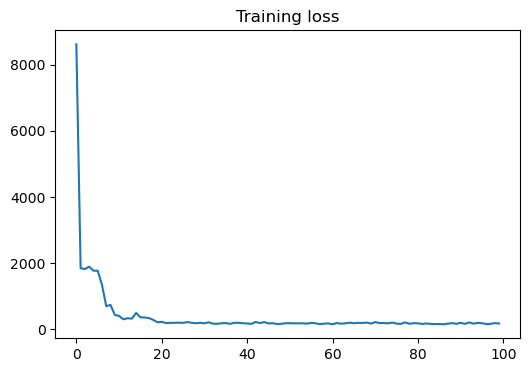

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4),ncols=1)

ax.plot(train_loss)
ax.set_title("Training loss")
plt.show()

A more sophisticated fitting algorithm was used in our implementations. <br> The function **spectral_NN_optim_best** is within the *`Important_functions`* module.

 - `Ifn.spectral_NN_optim_best(x,u,model,loss,optimizer,epoch,burn_in,interval,checkpoint_file)`
 
**Parameters:**
> * x ---- input functional time series. A matrix of size NxD, where D is the resolution (number of grid locations).
> * u ---- locations at which each functional data are observed. A matrix of size Dxd.
> * model ---- a spectral-NN model.
> * loss ---- loss function computation module, used to compute the loss which will be minimized. <br>
 In our context, the relevant function is **Ifn.loss_spectralNN**.
> * optimizer ---- an optimizer for optimizing the model. <br>
 An element from **torch.optim**, initiated with **model.params**
> * epochs ---- number of epochs to run the optimizer (optional, default: 1000).
> * burn_in ---- number of epochs before initiating *early stopping* (optional, default: 500).
> * interval ---- interval to wait before checking for early stopping (optional, default: 10).
> * checkpoint_file ---- file to save the interim states of early stopping (optional, default: "Checkpoint.pt").<br>
 **Note:** The parameters (optimizer, epochs, burn_in, interval) are set using the *`spectral_NN_setup.py`* module.
 
**Returns:**
> * l_tr -- an array containing the training losses.
> * epoch -- the number of epoch at which minimum loss was achieved.

In [8]:
l_tr, epoch = Ifn.spectral_NN_optim_best(x,u,model,loss,optimizer)

print("Minimum error {:.4f} achieved at epoch {}" .format(l_tr[epoch-1], epoch))

Minimum error 9.8754 achieved at epoch 980


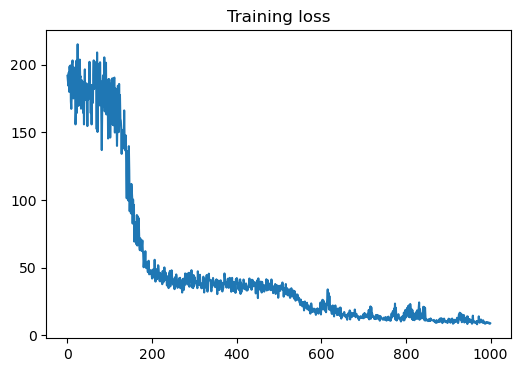

In [9]:
fig, ax = plt.subplots(figsize=(6,4),ncols=1)

ax.plot(l_tr)
ax.set_title("Training loss")
plt.show()

Once fitted, we can check the estimation error of the fitted model. Some useful functions are in the *`Important_functions`* module.

In [10]:
spect_dens_est = Ifn.spectral_density_evaluation(model, q=20, wt_fn=Ifn.kern_parzen)

theta_file = os.path.join("Demo-data","True_thetas.dat")
loc_file = os.path.join("Demo-data","True_locations.dat")
spect_file = os.path.join("Demo-data","True_spectrum.dat")

test_err,num,den,tr_cospect,tr_quadspect,err_cospect,err_quadspect = Ifn.spectral_error_computation(spect_dens_est,theta_file,loc_file,spect_file)

In [11]:
print("Relative estimation error - {:.2f}%\n" .format(test_err*100))
print("Co-spectra: Estimation error - {:.6f}, Actual - {:.6f} \n" .format(err_cospect,tr_cospect))
print("Quad-spectra: Estimation error - {:.6f}, Actual - {:.6f} \n" .format(err_quadspect,tr_quadspect))

Relative estimation error - 14.25%

Co-spectra: Estimation error - 0.000196, Actual - 0.001506 

Quad-spectra: Estimation error - 0.000074, Actual - 0.000000 



A spectral-NN model can be easily saved and restored using **torch.save** and **torch.load** functions in pytorch (see __https://pytorch.org/tutorials/beginner/saving_loading_models.html__).

**Usage:**
> * `torch.save(model.state_dict(), checkpoint)` ---- saves the current parameters of *model* to the file *checkpoint* (with extension .pt).
> * `model.load_state_dict(torch.load(checkpoint, weights_only=True))` ---- loads parameters from the file *checkpoint* and assigns them to the *model* <br>
 **Note:** For loading the parameters, the size of the *model* (N,d,M,L,depth,width etc.) should match exactly with the one in *checkpoint*. Otherwise, an error will be raised.

In [12]:
torch.save(model.state_dict(),"checkpoint.pt")
    # saving the current parameters to "checkpoint.pt"

In [13]:
model.load_state_dict(torch.load("checkpoint.pt", weights_only=True))
    # restoring the saved parameters

<All keys matched successfully>